<a href="https://colab.research.google.com/github/p-owens/MAI/blob/main/MAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras


#borrowed form 5c16
from keras import datasets
from keras.layers import Dense, Flatten, Dropout, Activation
from keras.regularizers import l2

from keras.models import model_from_json

from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator

import pickle
import sklearn as skl

from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score

In [28]:
# Define some useful functions
class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
        

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        
        self.i += 1
        
        clear_output(wait=True)
        plt.figure(figsize=(16, 6))
        plt.plot([1, 2])
        plt.subplot(121) 
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title('Model Loss')
        plt.legend()
        plt.subplot(122)         
        plt.plot(self.x, self.acc, label="training accuracy")
        plt.plot(self.x, self.val_acc, label="validation accuracy")
        plt.legend()
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.title('Model Accuracy')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();
        
        print("Training Accuracy: ", self.acc)
        
def save_model_to_disk():    
    # save model and weights (don't change the filenames)
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("model.h5")
    print("Saved model to model.json and weights to model.h5")

In [45]:
#retreiving both datasets from GitHub
git_xval = 'https://raw.githubusercontent.com/p-owens/MAI/main/x_val.csv'
git_yval = 'https://raw.githubusercontent.com/p-owens/MAI/main/y_val.csv'
df0 = pd.read_csv(git_xval,
                index_col=False,
                 header=None
                 )
df1 = pd.read_csv(git_yval,
                index_col=False,
                 header=None
                 )

In [46]:
x_values = df0.to_numpy()
y_values = df1.to_numpy()

y_values = y_values[:,0]
x_values = x_values[1::2,:]
print(x_values[0:2,:])
print(y_values[0:20])
print(y_values.shape)
print(x_values.shape)


[[1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1.
  1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0.
  1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1.]]
[1.38589439 1.4471488  0.         1.10415431 1.76300941 1.19643271
 1.8506994  0.         0.         0.         0.         0.
 1.42425867 1.24256777 1.38136267 0.         1.15511596 0.
 1.51584834 1.39263952]
(11972,)
(11972, 44)


In [47]:
#generate the test dataset
x_rem, x_test, y_rem, y_test = skl.model_selection.train_test_split(x_values, y_values, test_size=.1, random_state=0)

#generate the validation and training datasets
x_train, x_val, y_train, y_val = skl.model_selection.train_test_split(x_rem, y_rem, test_size=.2, random_state=0)

In [48]:
print(y_test.shape)
print(x_test.shape)
print(y_val.shape)
print(x_val.shape)
print(y_train.shape)
print(x_train.shape)

(1198,)
(1198, 44)
(2155,)
(2155, 44)
(8619,)
(8619, 44)


In [53]:
inputs = keras.layers.Input(shape=(44,))

x = Dense(88, activation='relu')(inputs)
x = Dropout(0.45)(x) # Drop out random 2% to prevent overfitting
x = Dense(88, activation='linear')(x)
x = Dropout(0.45)(x) # Drop out random 25% to prevent overfitting
x = Dense(88, activation='relu')(x)
x = Dropout(0.45)(x) # Drop out random 2% to prevent overfitting
x = Dense(44, activation='linear')(x)
x = Dropout(0.45)(x) # Drop out random 25% to prevent overfitting



predictions = Dense(1, activation='relu')(x)

# we create the model 
model = keras.models.Model(inputs=inputs, outputs=predictions)
opt = keras.optimizers.SGD(lr=0.02, decay=1e-6, momentum=0.99, nesterov=True)
# opt = keras.optimizers.Adadelta()

# setup the optimisation strategy
model.compile(optimizer=opt,
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanAbsoluteError()])


model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 44)]              0         
_________________________________________________________________
dense_25 (Dense)             (None, 88)                3960      
_________________________________________________________________
dropout_20 (Dropout)         (None, 88)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 88)                7832      
_________________________________________________________________
dropout_21 (Dropout)         (None, 88)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 88)                7832      
_________________________________________________________________
dropout_22 (Dropout)         (None, 88)                0   

In [59]:
pltCallBack = PlotLossAccuracy()

# and train
history = model.fit(x_train, y_train,
                    batch_size=4096, epochs=100, 
                    validation_data=(x_val, y_val), 
                    verbose=0)


#callbacks=[pltCallBack]          

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


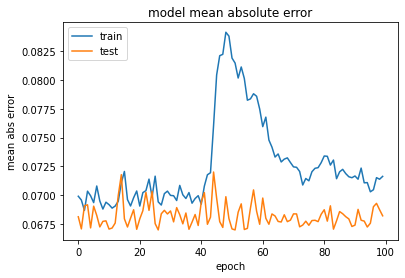

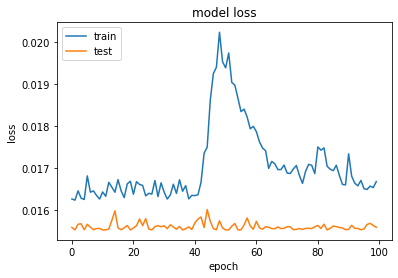

In [60]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean absolute error')
plt.ylabel('mean abs error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [70]:
results = model.evaluate(x_test,y_test, verbose=1)
#print(model.metrics_names[0] + " : " + str(results[0]) + "\n" + model.metrics_names[1] + " : " + str(results[1]))

38/38 [==============================] - 0s 2ms/step - loss: 0.0181 - mean_absolute_error: 0.0691
